In [9]:
import sys

sys.path.append('..')
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tfvpc.model.resnet2D import Resnet2DBuilder
from tfvpc.preprocessing.two_dim import load_batch_dataset
from tfvpc.preprocessing.two_dim import count_tfrecord_examples
from tfvpc.utils.vis import show_confusion_matrix
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tfvpc.model.unet import UNet
from tfvpc.model.shnet2D import ShadowNet



In [10]:
w_path = '../checkpoints/'
out_path = '../data/tfrecods/'
out_test_fname = 'val-2D-5cls-02'
out_val_fname = 'test-2D-5cls-02'
model_fname = '../checkpoints/shnet-2D-5cls-03_checkpoint.h5'
out_val_ffname = os.path.join(out_path, out_val_fname + '.tfrecords')
out_test_ffname = os.path.join(out_path, out_test_fname + '.tfrecords')

# patch size: [n_rows, n_cols, n_planes]
n_rows = 32
n_cols = 32
n_classes = 5
vocab = [2,3,4,5,6]
n_channel = 1
epoch = 100
lr = 1e-5
batch_size = 128


seed = 2020
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [11]:
val_dataset = load_batch_dataset(epoch,
                                 batch_size, 
                                 out_val_ffname,
                                 vocab,
                                 n_classes,
                                 aug =False, train=False)
print(f'nm of samples: {count_tfrecord_examples(out_val_ffname)}')
print(val_dataset.element_spec)

nm of samples: 43227
(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))


# define model and load weights

In [12]:
params_model = dict(
    img_width=n_rows,
    img_height=n_cols,
    n_channels=1,
    n_classes=n_classes,
    n_filters = 8,
    batch_normalization=True,
    class_names=['0', '1', '2','3','4'],
)
unet = ShadowNet(**params_model)
unet.summary()

#metrics
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]
#compile model
opt = tf.keras.optimizers.Adam(learning_rate=lr)
unet.compile(optimizer=opt,
               loss=tf.keras.losses.categorical_crossentropy,
               metrics=metrics)
unet.load_weights(model_fname)
# resnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 8)         80        
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 32, 32, 8)         32        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 8)         584       
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 32, 32, 8)         32        
_________________________________________________________________
block1_mp (MaxPooling2D)     (None, 16, 16, 8)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 16)        1168

In [13]:
results = unet.evaluate(val_dataset, batch_size=64)

338/338 [==============================] - 3s 5ms/step - loss: 0.5712 - accuracy: 0.8871 - precision: 0.8883 - recall: 0.8859 - auc: 0.9636 - prc: 0.9074


In [14]:
validation_array = np.array(list(val_dataset.unbatch().take(-1).as_numpy_iterator()))
val_x = np.stack(validation_array[:,0])
val_y = np.stack(validation_array[:,1])
print(val_x.shape, val_y.shape)
# test_lbls_pred = np.argmax(resnet.predict(test_imgs), axis=1)
test_lbls_pred = np.argmax(unet.predict(val_x), axis=1)
test_lbls_gt =  np.argmax((val_y), axis=1)

/home/ubuntu/anaconda2/envs/lta/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(43227, 32, 32, 1) (43227, 5)


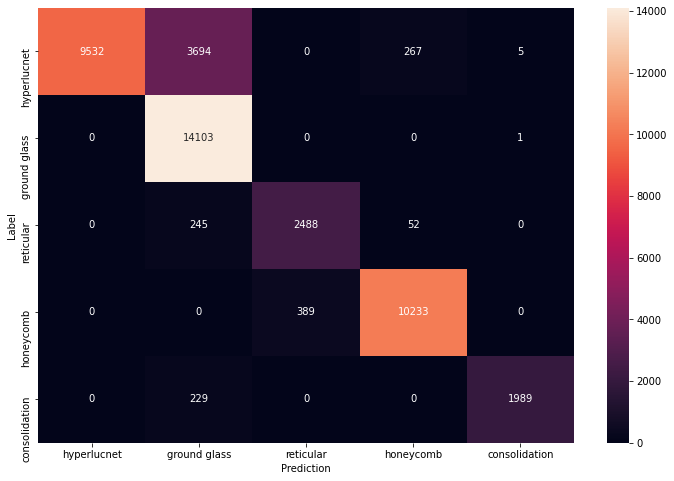

In [15]:
cf_matrix = tf.math.confusion_matrix(test_lbls_gt, test_lbls_pred)
label_names = ['hyperlucnet','ground glass','reticular','honeycomb','consolidation']
show_confusion_matrix(cf_matrix, label_names)
n_per_class = cf_matrix.numpy().sum(axis=1)
tp_plus_fp_per_class = cf_matrix.numpy().sum(axis=0)
tp_per_class = tf.linalg.diag_part(cf_matrix).numpy()
fp_per_class = tp_plus_fp_per_class - tp_per_class
fn_per_class = n_per_class - tp_per_class
# tn_per_class = tp_per_class.sum() - tp_per_class
tn_per_class = cf_matrix.numpy().sum() - tp_per_class - fp_per_class - fn_per_class
# acc_per_class = tp_per_class / n_per_class
acc_per_class = (tp_per_class+tn_per_class) / (tp_per_class + fn_per_class + tn_per_class + fp_per_class)
precision_per_class = tp_per_class / tp_plus_fp_per_class
recall_per_class = tp_per_class / (tp_per_class + fn_per_class)
specificity_per_class = tn_per_class / (tn_per_class + fp_per_class) 
ba_acc_per_class = (specificity_per_class + recall_per_class) / 2


In [16]:
data = {
    'class': ['hyperlucnet','ground glass','reticular','honeycomb','consolidation', 'macro-avg', 'micro-avg'],
    'accuracy_valid': acc_per_class.tolist() + [acc_per_class.mean(), results[1]],
    'ba_accuracy_valid': ba_acc_per_class.tolist() + [ba_acc_per_class.mean(), '-'],
    'sensitivity_valid': recall_per_class.tolist() + [recall_per_class.mean(), results[3]],
    'precision_valid': precision_per_class.tolist() + [precision_per_class.mean(), results[2]],
    'specificity_valid': specificity_per_class.tolist() + [specificity_per_class.mean(), '-'],
}
df = pd.DataFrame(data=data)
df.style \
    .set_properties(**{
        'text-align': 'center', 
        'width': '120px',
        'font-size': '16px',
        'precision':3
    }) \
    .set_precision(3)

#### Performance metrics
$$\text{accuracy} = \frac{\text{true positives}+ \text{true negatives}}{\text{true positives}+ \text{false negatives} + + \text{true negatives}+\text{false negatives}}$$

$$\text{balanced accuracy} = \frac{\text{specificity} + \text{sensitivity} }{\text{2} }$$

$$\text{precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positive}}$$

$$\text{sensitivity} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

$$\text{specificity} = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives}}$$


## Test data

In [17]:
test_dataset = load_batch_dataset(epoch,
                                  batch_size,
                                  out_test_ffname,
                                  vocab,
                                  n_classes,
                                  aug = False,
                                  train=False)
print(f'nm of test samples: {count_tfrecord_examples(out_test_ffname)}')
print(test_dataset.element_spec)

validation_array = np.array(list(test_dataset.unbatch().take(-1).as_numpy_iterator()))
test_x = np.stack(validation_array[:,0])
test_y = np.stack(validation_array[:,1])
print(test_x.shape, test_y.shape)

test_lbls_pred = np.argmax(unet.predict(test_x), axis=1)
test_lbls_gt =  np.argmax((test_y), axis=1)

nm of test samples: 93800
(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))


/home/ubuntu/anaconda2/envs/lta/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


(93800, 32, 32, 1) (93800, 5)


In [18]:
results = unet.evaluate(test_dataset, batch_size=batch_size)

733/733 [==============================] - 4s 5ms/step - loss: 0.6815 - accuracy: 0.8301 - precision: 0.8307 - recall: 0.8295 - auc: 0.9571 - prc: 0.8684


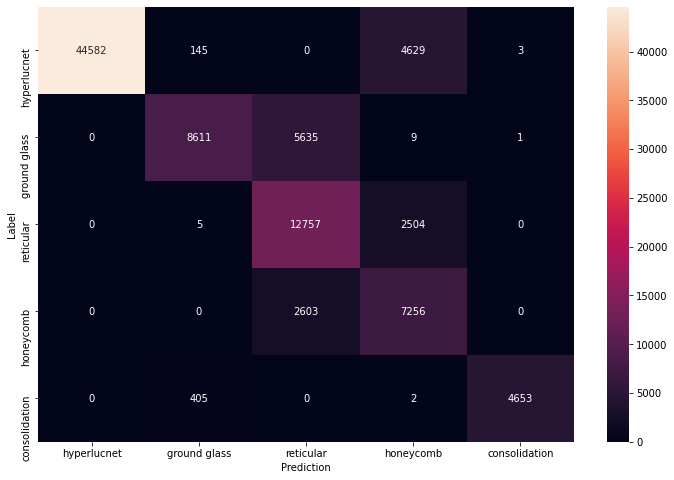

In [19]:
cf_matrix = tf.math.confusion_matrix(test_lbls_gt, test_lbls_pred)
label_names = ['hyperlucnet','ground glass','reticular','honeycomb','consolidation']
show_confusion_matrix(cf_matrix, label_names)
n_per_class = cf_matrix.numpy().sum(axis=1)
tp_plus_fp_per_class = cf_matrix.numpy().sum(axis=0)
tp_per_class = tf.linalg.diag_part(cf_matrix).numpy()
fp_per_class = tp_plus_fp_per_class - tp_per_class
fn_per_class = n_per_class - tp_per_class
# tn_per_class = tp_per_class.sum() - tp_per_class
tn_per_class = cf_matrix.numpy().sum() - tp_per_class - fp_per_class - fn_per_class
# acc_per_class = tp_per_class / n_per_class
acc_per_class = (tp_per_class+tn_per_class) / (tp_per_class + fn_per_class + tn_per_class + fp_per_class)
precision_per_class = tp_per_class / tp_plus_fp_per_class
recall_per_class = tp_per_class / (tp_per_class + fn_per_class)
specificity_per_class = tn_per_class / (tn_per_class + fp_per_class) 


In [20]:
data = {
    'class': ['hyperlucnet','ground glass','reticular','honeycomb','consolidation', 'macro', 'micro'],
    'accuracy_test': acc_per_class.tolist() + [acc_per_class.mean(), results[1]],
    'recall_test': recall_per_class.tolist() + [recall_per_class.mean(), results[3]],
    'precision_test': precision_per_class.tolist() + [precision_per_class.mean(), results[2]],
    'specificty_test': specificity_per_class.tolist() + [specificity_per_class.mean(), None],
}
df = pd.DataFrame(data=data)
df.style \
    .set_properties(**{
        'text-align': 'center', 
        'width': '150px',
        'font-size': '16px',
        'precision':3
    }) \
    .set_precision(2)
